## 기본 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imagehash > /dev/null

In [ ]:
filepath = '/content/drive/MyDrive/Project II/pet_data/'
modelpath = '/content/drive/MyDrive/Project II/model/'
train_path = filepath + 'train/'
cat_path = train_path + 'cat/'
dog_path = train_path + 'dog/'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob
import sys
import cv2
import imageio
import joblib
import math
import warnings
import os
import torch
import imagehash
import matplotlib.patches as patches

In [ ]:
# 강아지 얼굴 인식
# import cv2
import dlib, os
from imutils import face_utils

## YOLOv5를 사용해서 동물 객체의 범위 받아오기?

 - 아래 내용은 [캐글 참고](https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords)
 에서 가져왔음

In [ ]:
# Download YOLOV5 GitHub Repo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9755, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 9755 (delta 34), reused 27 (delta 27), pack-reused 9713
Receiving objects: 100% (9755/9755), 10.05 MiB | 4.50 MiB/s, done.
Resolving deltas: 100% (6778/6778), done.


In [ ]:
# Load Best Performing YOLOV5X Model
yolov5x6_model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-10-25 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)



  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/269M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


- 이미지 분석 함수 YOLOv5를 사용하고 있고 캐글에서 만든 함수를 수정하여 사용중

In [ ]:
%matplotlib inline 

In [ ]:
# Get Image Info
def get_image_info(file_path, plot=False):
    # Read Image
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, c = image.shape
    
    # 그래프
    if plot: # Debug Plots
        fig, ax = plt.subplots(1, 2, figsize=(8,8))
        ax[0].set_title('Pets detected in Image', size=16)
        ax[0].imshow(image)
        
    # Get YOLOV5 results using Test Time Augmentation for better result
    results = yolov5x6_model(image, augment=True)
    
    # Mask for pixels containing pets, initially all set to zero
    pet_pixels = np.zeros(shape=[h, w], dtype=np.uint8)
    
    # Dictionary to Save Image Info
    h, w, _ = image.shape # 높이, 너비, 차원
    image_info = { 
        'name': '',
        'n_pets': 0, # Number of pets in the image
        'labels': [], # Label assigned to found objects 
        'human' : 0, # 사람의 신체부위나 사람이 나타나는 경우
        'face' : 0, # 얼굴이 정면을 조금이라도 보고있으면 (사진에 2개의 동공이 잡히는 경우 1)
        'face_rects': [], # 얼굴 사각형
        'thresholds': [], # confidence score
        'coords': [], # coordinates of bounding boxes
        'x_min': 0, # minimum x coordinate of pet bounding box
        'x_max': w - 1, # maximum x coordinate of pet bounding box
        'y_min': 0, # minimum y coordinate of pet bounding box
        'y_max': h - 1, # maximum x coordinate of pet bounding box
    }
    
    image_info['name'] = file_path.split('/')[-1][:-4]

    # 강아지 얼굴을 찾는 함수
    dets = detecte_dog_faces(image)
    if dets:
      image_info['face'] = 1
      # print(f'dets = {dets}')
      for d in dets:
        image_info['face_rects'].append(tuple([d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()]))



    # Save found pets to draw bounding boxes
    pets_found = []
    
    # Save info for each pet
    for x1, y1, x2, y2, treshold, label in results.xyxy[0].cpu().detach().numpy():
        label = results.names[int(label)]
        # print(f'label : {label}')
        
        # image_info 저장
        if label in ['cat', 'dog']:
          image_info['n_pets'] += 1
          # Set pixels containing pets to 1
          pet_pixels[int(y1):int(y2), int(x1):int(x2)] = 1 # label이 cat, dog인 경우만 pet의 범위로 지정

        if label in ['Human']: # 사람의 신체부위가 나타나는 경우
          image_info['Human'] += 1

        image_info['labels'].append(label)
        image_info['thresholds'].append(treshold)
        image_info['coords'].append(tuple([x1, y1, x2, y2]))
        image_info['x_min'] = max(x1, image_info['x_min'])
        image_info['x_max'] = min(x2, image_info['x_max'])
        image_info['y_min'] = max(y1, image_info['y_min'])
        image_info['y_max'] = min(y2, image_info['y_max'])
            

        # Add found pet
        pets_found.append([x1, x2, y1, y2, label])

    # 그래프
    if plot:
        for x1, x2, y1, y2, label in pets_found:
            c = 'red' if label == 'dog' else 'blue'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=c, facecolor='none')
            # Add the patch to the Axes
            ax[0].add_patch(rect)
            ax[0].text(max(25, (x2+x1)/2), max(25, y1-h*0.02), label, c=c, ha='center', size=14)
                
    # Add Pet Ratio in Image
    print(f'pet_ratio : {pet_pixels.sum() / (h*w)}')
    image_info['pet_ratio'] = pet_pixels.sum() / (h*w)

    if plot:
        # Show pet pixels
        ax[1].set_title('Pixels Containing Pets', size=16)
        ax[1].imshow(pet_pixels)
        plt.show()
        
    return image_info

In [ ]:
# image 정보를 출력하는 함수.. 

def print_info(img_info):
  print('-'*5)
  print(f'''{img_info['name']}에는 {img_info['n_pets']}마리의 반려동물이 있습니다.
  {str(img_info['human']) +'명의 사람이 있으며' if img_info['human'] > 0 else ''}
  동물이 차지하는 범위는 약 {np.round(img_info['pet_ratio'], 2) * 100}%입니다.
  이 동물의 얼굴은 { '잘 보이며' if img_info['face'] == 1 else '안 보이며'}
  아주 귀엽습니다.  
  ''')
  print('-'*5)

# Load Models

In [ ]:
# GPU 런타임 필요 https://realist.tistory.com/m/11
detector = dlib.cnn_face_detection_model_v1(modelpath + 'dogHeadDetector.dat')
predictor = dlib.shape_predictor(modelpath + 'landmarkDetector.dat')

# Load Dog Image

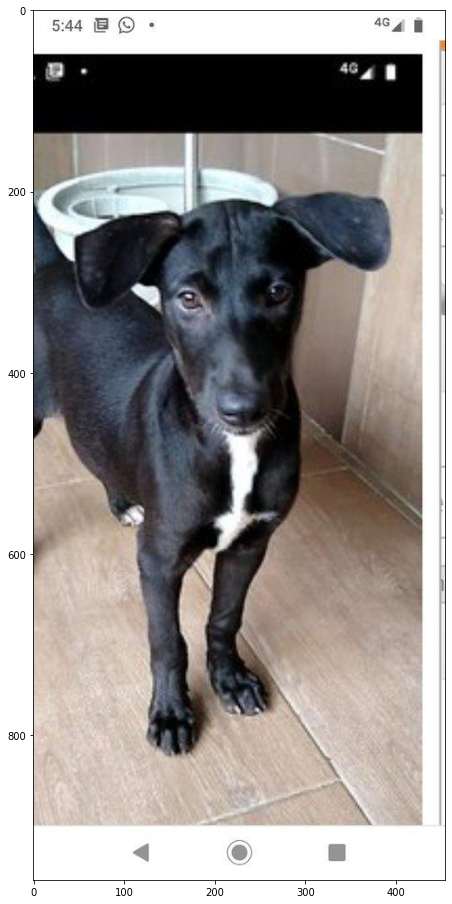

In [ ]:
img_path = dog_path + 'dog66.jpg'
# filename, ext = os.path.splitext(os.path.basename(img_path))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)

plt.figure(figsize=(16, 16))
plt.imshow(img)

# Detect Faces

- face : 두 눈이 보여야 함. 으로 인식
- eyes : 

In [ ]:
def detecte_dog_faces(img):
  # detector를 통해 얼굴을 찾아옴
  dets = detector(img, upsample_num_times=1) 

  img_result = img.copy()

  # 강아지 얼굴에 빨간 네모로 표시
  for i, d in enumerate(dets):
      
      # print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

      x1, y1 = d.rect.left(), d.rect.top()
      x2, y2 = d.rect.right(), d.rect.bottom()

      cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
      
  plt.figure(figsize=(8, 8))
  plt.imshow(img_result)

  return dets

In [ ]:
def info_to_dict(img_info):

  
  df = pd.DataFream()

pet_ratio : 0.51498125
-----
dog2330에는 1마리의 반려동물이 있습니다.
  
  동물이 차지하는 범위는 약 51.0%입니다.
  이 동물의 얼굴은 잘 보이며
  아주 귀엽습니다.  
  
-----


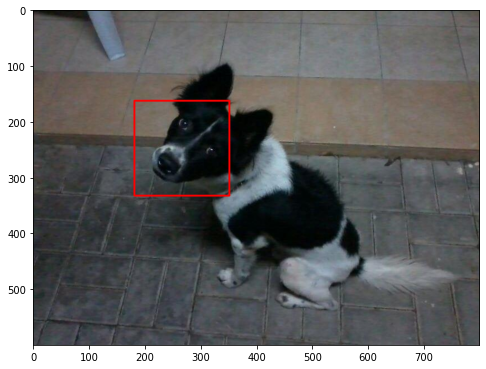

In [ ]:
img_path = dog_path + 'dog2330.jpg'
print_info(get_image_info(img_path))

# Detect Landmarks

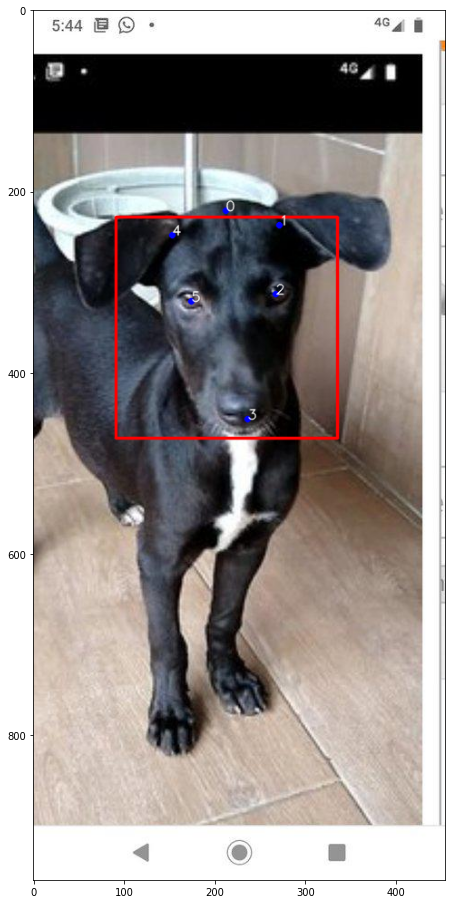

In [ ]:
shapes = []

# 강아지 얼굴에 점을 찍어주는 함수
for i, d in enumerate(dets):
    shape = predictor(img, d.rect)
    shape = face_utils.shape_to_np(shape)
    
    for i, p in enumerate(shape):
        shapes.append(shape)
        cv2.circle(img_result, center=tuple(p), radius=3, color=(0,0,255), thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# img_out = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
# cv2.imwrite(f'{img_path}', img_out) # 이미지 저장.
plt.figure(figsize=(16, 16))
plt.imshow(img_result)

### 상관계수 구해보기


In [ ]:
cdf = pd.read_csv(filepath + 'n_cat.csv')
ddf = pd.read_csv(filepath + 'n_dog.csv')

In [ ]:
cdf.corr()

In [ ]:
ddf.corr()

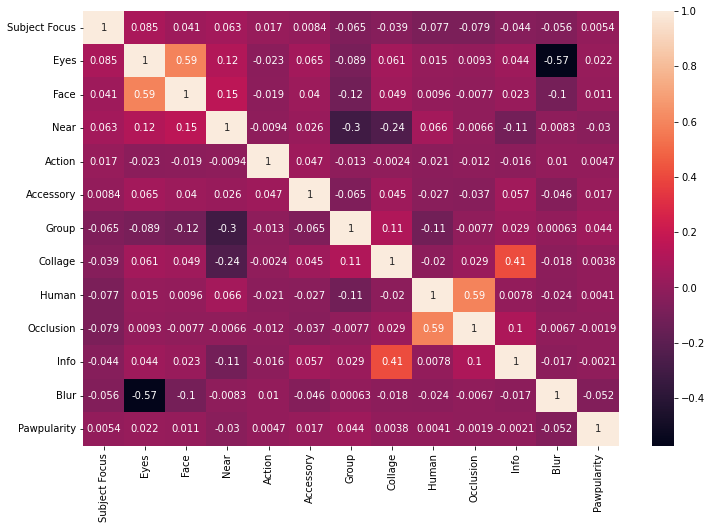

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(cdf.corr(), annot=True)
plt.show()

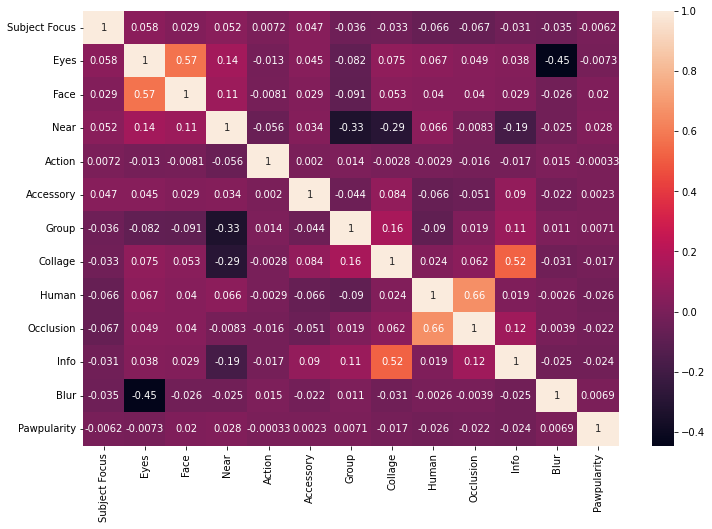

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(ddf.corr(), annot=True)
plt.show()